# Homework 4
#### By Group 16
In this homework you are to study, implement and to test the spectral graph clustering algorithm as described in the paper “On Spectral Clustering: Analysis and an algorithm” by Andrew Y. Ng, Michael I. Jordan, Yair Weiss. Using your implementation of the K-eigenvector algorithm, you are to analyse two sample graphs.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

### Part 1: A Real Graph
The dataset contains of 2196 edges. All edges in the dataset are distinct and have no self-loops. No weight is given for the edges, so we assume that the weight between node A and B is equal to one if node A and node B are connected and zero otherwise. Note that the tuples are not coordinates of the points, but represents the ids of the nodes which are linked together.

In [2]:
df = pd.read_csv('example1.dat', sep=",", header=None)  
print(f"The number of edges is equal to {len(df)}")

The number of edges is equal to 2196


We first plot the original graph without having applied clustering:

In [3]:
graph = nx.from_pandas_edgelist(df,0,1) # df has columns named 0, 1

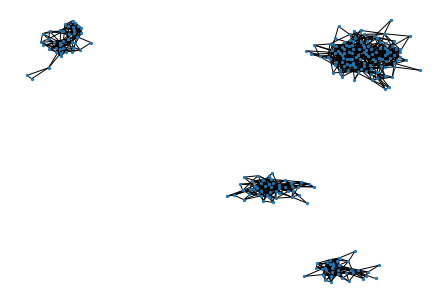

In [4]:
nx.draw(graph,node_size=5)

Given a set of points $S=\{s_1, \ldots, s_n\}$ in $\mathbb{R}^l$ that we want to cluster into k subsets:

1. Form the affinity matrix A defined by $A_{ij}=e^{-||s_i-s_j||^2/2 \sigma^2)}$ if $i \neq j$, and $A_{ij}=0$.

An affinity matrix is just like an adjacency matrix, except the value for a pair of points expresses how similar those points are to each other. If pairs of points are very dissimilar then the affinity should be 0. If the points are identical, then the affinity might be 1. In this way, the affinity acts like the weights for the edges on our graph. Thus affinity matrix represents the weighted links. In our case, if the nodes are connected then the weight is equal to one, otherwise zero. 

In [5]:
A = np.array(nx.adjacency_matrix(graph).todense())
print(A)

[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


2. Define $D$ to be the diagonal matrix whose $(i,i)$-element is the sum of $A$'s $i$-th row, and construct the matrix $L=D^{-1/2} AD^{-1/2}$.

In [6]:
D = np.diag(np.sum(A, axis=1)) #0 or 1 because it is symmetrical
Dsqrt = np.sqrt(D)
Dfinal = np.linalg.inv(Dsqrt)
print(D)

[[7 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 9 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 2]]


In [7]:
L = np.dot(Dfinal,np.dot(A,Dfinal))
print(L)

[[0.         0.13363062 0.12598816 ... 0.         0.         0.        ]
 [0.13363062 0.         0.         ... 0.         0.         0.        ]
 [0.12598816 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


3. Find $x_1, x_2, \ldots, x_k$, the $k$ largest eigenvectors of $L$ (chosen to be orthogonal to each other in the case of repeated eigenvalues), and form the matrix $X=[x_1x_2 \ldots x_k] \in \mathbb{R}^{n \times k}$ by stacking the eigenvectors in columns. 

In [8]:
#eigh will return sorted eigenvalues and is faster because it takes advantage of the symmetry of the matrix
eigenvalues, eigenvectors = np.linalg.eigh(L)

Here we estimate the value for $k$ by finding the index of the eigenvalue that has the biggest eigengap with its predecessor. A large eigenvalue indicates that a large amount of information is represented by the eigenvector. Then, if the next eigenvalue differs significantly from it predecssor, then this implies that most of the information if represented by the previous eigenvectors. Hence, there is no need for adding a new cluster. So by estimating the value of $k$, we obtain the biggest difference between the eigenvalues.

In [9]:
lista = list(eigenvalues)
#we select k to be where the eigengap is the biggest
# -1 because we check n-1 differences
#i substract from the number of eigenvalues because we want the largest eigenvalues and they are sorted with ascending
k = len(lista) - 1 - np.argmax([x - lista[i - 1] for i, x in enumerate(lista)][1:])  
print(f"We estimate k to be equal to {k}")

We estimate k to be equal to 4


In [10]:
sel_eigen = eigenvectors[:,-k:] #ordered as seen in eigenvectors
print(len(sel_eigen) == len(set(list(df[0])+list(df[1])))) # check dimensions
print(len(sel_eigen[0]) == k)

True
True


4. Form the matrix $Y$ from $X$ by renormalizing each of $X$'s rows to have unit length (i.e. $Y_{ij}=X_{ij} / (\sum_{j} X_{ij}^2)^{1/2}$.

In [11]:
Y = []
for i in sel_eigen:
    div = np.linalg.norm(i)   #by default norm2 
    Y.append(i/div) 
Yfinal = np.array(Y)    

5. Treating each row of $Y$ as a point in $\mathbb{R}^k$, cluster them into $k$ clusters via K-means or any other algorithm that attempts to minimize distortion. 

In [12]:
clusters = KMeans(n_clusters=k).fit(Yfinal)
labels = clusters.labels_

6. Finally, assign the original point $s_i$ to cluster $j$ iff row $i$ of the matrix $Y$ was assigned to cluster $j$. 

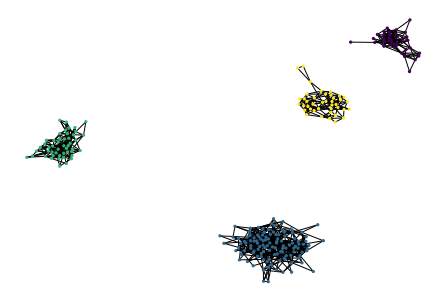

In [13]:
nx.draw(graph, node_size=5, node_color=labels)
plt.show()

### Part 2: A Synthetic Graph
The following dataset has the same structure as the dataset in part 1. It, however, consists of an extra column which consists of only values 1. So, the assumption we made previously in part 1 still holds here.

In [14]:
df2 = pd.read_csv('example2.dat', sep=",", header=None)
print(f"The number of edges is equal to {len(df2)}")

The number of edges is equal to 2418


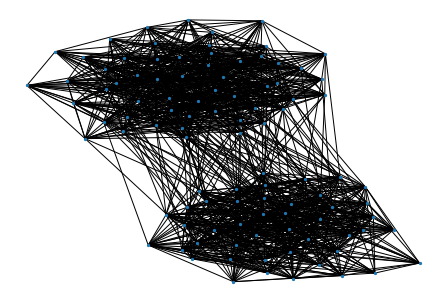

In [15]:
graph2 = nx.from_pandas_edgelist(df2,0,1)
nx.draw(graph2,node_size=5)
plt.show()

Given a set of points $S=\{s_1, \ldots, s_n\}$ in $\mathbb{R}^l$ that we want to cluster into k subsets:

1. Form the affinity matrix A defined by $A_{ij}=e^{-||s_i-s_j||^2/2 \sigma^2)}$ if $i \neq j$, and $A_{ij}=0$.

An affinity matrix is just like an adjacency matrix, except the value for a pair of points expresses how similar those points are to each other. If pairs of points are very dissimilar then the affinity should be 0. If the points are identical, then the affinity might be 1. In this way, the affinity acts like the weights for the edges on our graph. Thus affinity matrix represents the weighted links. In our case, if the nodes are connected then the weight is equal to one, otherwise zero. 

In [16]:
A2 = np.array(nx.adjacency_matrix(graph2).todense())
print(A2)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


2. Define $D$ to be the diagonal matrix whose $(i,i)$-element is the sum of $A$'s $i$-th row, and construct the matrix $L=D^{-1/2} AD^{-1/2}$.

In [17]:
D2 = np.diag(np.sum(A2, axis=1))
Dsqrt2 = np.sqrt(D2)
Dfinal2 = np.linalg.inv(Dsqrt2)
print(Dfinal2)

[[0.24253563 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20851441 0.         ... 0.         0.         0.        ]
 [0.         0.         0.23570226 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.2236068  0.         0.        ]
 [0.         0.         0.         ... 0.         0.2        0.        ]
 [0.         0.         0.         ... 0.         0.         0.25      ]]


In [18]:
L2 = np.dot(Dfinal2,np.dot(A2,Dfinal2))
print(L2)

[[0.         0.05057217 0.         ... 0.         0.         0.        ]
 [0.05057217 0.         0.04914732 ... 0.         0.         0.        ]
 [0.         0.04914732 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


3. Find $x_1, x_2, \ldots, x_k$, the $k$ largest eigenvectors of $L$ (chosen to be orthogonal to each other in the case of repeated eigenvalues), and form the matrix $X=[x_1x_2 \ldots x_k] \in \mathbb{R}^{n \times k}$ by stacking the eigenvectors in columns. 

In [19]:
eigenvalues2, eigenvectors2 = np.linalg.eigh(L2)

Here we estimate the value for $k$ by finding the index of the eigenvalue that has the biggest eigengap with its predecessor. A large eigenvalue indicates that a large amount of information is represented by the eigenvector. Then, if the next eigenvalue differs significantly from it predecssor, then this implies that most of the information if represented by the previous eigenvectors. Hence, there is no need for adding a new cluster. So by estimating the value of $k$, we obtain the biggest difference between the eigenvalues.

In [20]:
listb = list(eigenvalues2)
k2 = len(listb) - 1 - np.argmax([x - listb[i - 1] for i, x in enumerate(listb)][1:])
print(f"We estimate k to be equal to {k2}")

We estimate k to be equal to 2


In [21]:
sel_eigen2 = eigenvectors2[:,-k2:]
print(len(sel_eigen2) == len(set(list(df2[0])+list(df2[1])))) # check dimensions
print(len(sel_eigen2[0]) == k2)

True
True


In [22]:
Y2 = []
for i in sel_eigen2:
    div = np.linalg.norm(i)   #by default norm2
    Y2.append(i/div) 
    
Yfinal2 = np.array(Y2) 

5. Treating each row of $Y$ as a point in $\mathbb{R}^k$, cluster them into $k$ clusters via K-means or any other algorithm that attempts to minimize distortion. 

In [23]:
clusters2 = KMeans(n_clusters=k2).fit(Yfinal2)
labels2 = clusters2.labels_

6. Finally, assign the original point $s_i$ to cluster $j$ iff row $i$ of the matrix $Y$ was assigned to cluster $j$. 

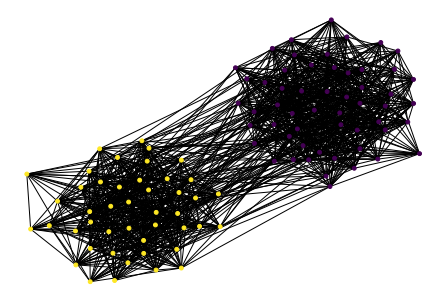

In [24]:
nx.draw(graph2, node_size=15, node_color=labels2)
plt.show()

### Part 3: Analysis and Comparison of the Datasets

Fiedler Vector: The eigenvector corresponding to second smallest eigenvalue of Laplacian matrix, L, is called Fiedler Vector. If the graph has two modules then it bisects the graph into only two communities based on the sign of the corresponding vector entry. If we plot the sorted Fiedler Vector it the communities in the graphs will be clearly visible. 
Other visualisations that may be useful for the analysis are the Sparsity Pattern and the Sorted Eigenvalues.                                                     

The **Sparsity Pattern** of the first dataset indicates that there is no overlap and we notice that there are indeed four well-distinguished communities: 

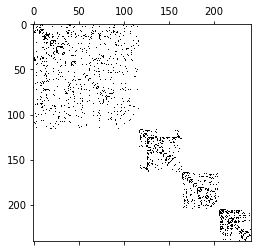

In [25]:
plt.spy(A); 

Whereas the **Sparsity Pattern** for the second dataset clearly shows a lot of overlap:

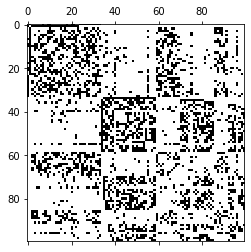

In [26]:
plt.spy(A2);

With regard to the **sorted eigenvalues** of the first dataset, the biggest difference between them corresponds to the fourth and fifth largest eigenvalues, although this is not very clear from _only_ the plot itself.

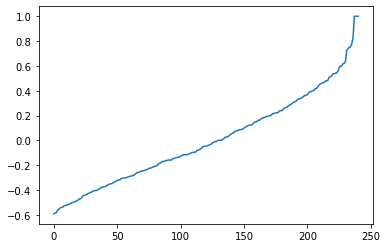

In [27]:
plt.plot(range(len(eigenvalues)),eigenvalues);

For the second dataset, this is however more clear. The biggest eigengap seems to be between the second and third largest eigenvalues:

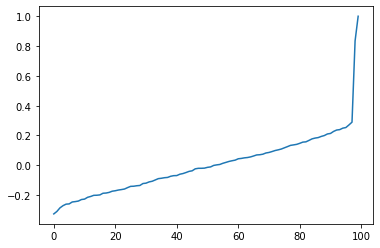

In [28]:
plt.plot(range(len(eigenvalues2)),eigenvalues2);

Lastly, the **Fiedler vector** for bi-partitioning only holds for when we have two clusters. For the first dataset with four clusters, we therefore see that for the first four, we have only positive or only negative values. The fifth, on the other hand, has some negatives and then some positives:

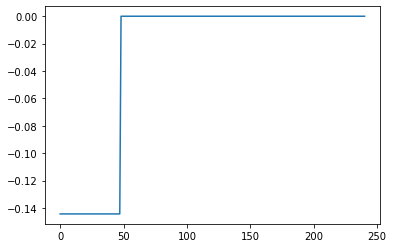

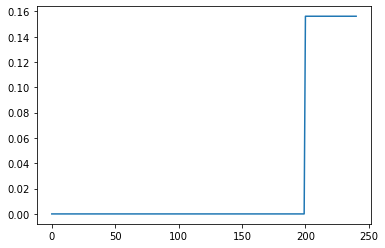

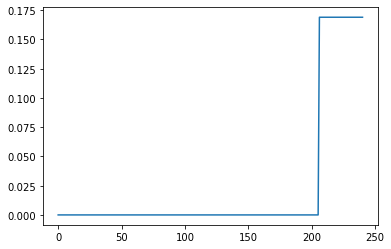

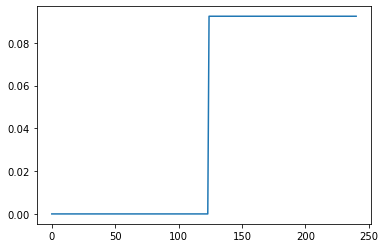

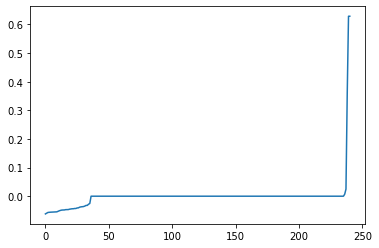

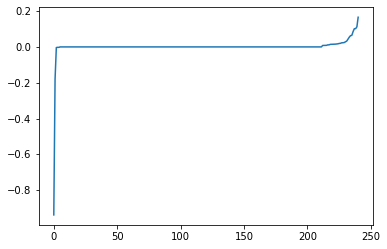

In [29]:
Laplacian = D - A
evalues, evectors = np.linalg.eigh(Laplacian)
for i in range(6):
    fiedler = sorted(evectors[:, i])
    plt.plot(range(len(fiedler)),fiedler) 
    plt.show()

For the second dataset with two clusters, we have the following **fiedler vector** for bi-partitioning namely one cluster with only negative values and another with only positive values. It is clear from the plot that there are at least two communities:

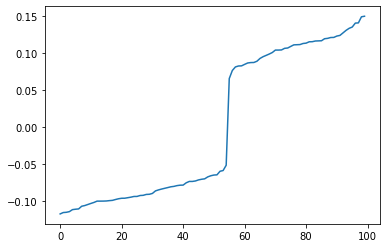

In [30]:
Laplacian2 = D2 - A2
evalues2, evectors2 = np.linalg.eigh(Laplacian2)
fiedler2 = sorted(evectors2[:, 1])
plt.plot(range(len(fiedler2)),fiedler2);

Finally, we again plot the **spectral clustering** result for both datasets. We see that for the first dataset there are four isolated communities which is in line with our analysis:

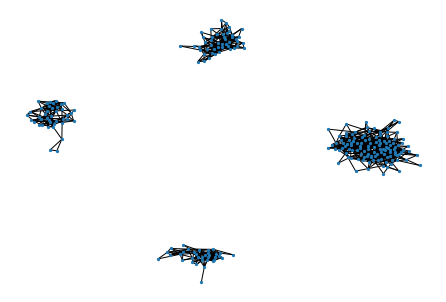

In [31]:
nx.draw(graph,node_size=5)

For the second dataset, the **spectral clustering** is as shown below and this result also is in line with our previous analysis as it shows that there are two interconnected clusters:

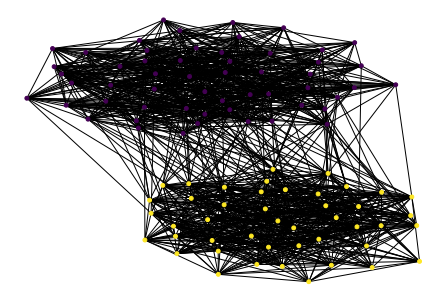

In [32]:
nx.draw(graph2, node_size=15, node_color=labels2)